# Perfect Model Experiments: Arctic Sea ice (sic/sit) 850--1850
  
Katie Brennan  
August 2020 
  
Experiments drawing observations from the CCSM4 last millennium run at the proxy locations and observations errors drawn from the Pages2kv2 dataset. They were then assimilated into a 200 member prior ensemble drawn from the CCSM4 last millennium run to test this techniqe in a perfect model environment from 850--1850. 
  
Here I want to investigate if there is a difference in performance as the number of observations increases with time. I want to look at the evolution of skill metrics like R$^2$ and CE values in time. Is there a section of time in 850--1850 that is more trustworthy that we should rely on more than others? 
  
Also I updated the code to include Sea ice thickness which I'd like to look at for my own curiosity. It may or may not end up in the paper. 

#### Conclusions: 



In [1]:
import sys,os,copy

In [2]:
import sys
import numpy as np
import pickle

from scipy import stats
from scipy import signal

import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.util import add_cyclic_point

In [3]:
sys.path.insert(1,'/home/disk/p/mkb22/Documents/si_analysis_kb/instrumental_assimilation_experiments/')
import reanalysis_recons_utils as rrutils

sys.path.insert(1,'/home/disk/kalman2/mkb22/LMR_lite/')
import LMR_utils 

sys.path.insert(1,'/home/disk/p/mkb22/Documents/si_utils_kb/')
import Sice_utils as siutils 
import stats_utils as kbstats

sys.path.insert(1,'/home/disk/p/mkb22/Documents/si_analysis_kb/common_era_experiments/')
import commonera_utils as ce_utils 

Loading information from datasets.yml
Loading information from grid_def.yml
Loading information from datasets.yml
Loading information from grid_def.yml


In [4]:
import importlib
# #importlib.reload(LMRlite)
# #importlib.reload(LMR_config)
# importlib.reload(LMRlite)
importlib.reload(ce_utils)

<module 'commonera_utils' from '/home/disk/p/mkb22/Documents/si_analysis_kb/common_era_experiments/commonera_utils.py'>

In [5]:
plt.rcParams['figure.dpi']=200

In [6]:
def load_ccsm4_lm_regridded():
    ccsm4_dir = '/home/disk/chaos/mkb22/Documents/SeaIceData/CCSM4/CCSM4_last_millennium/'
    ccsm4_file = 'ccsm4_sic_sit_tas_20CRv2_850_1850_full.npz'

    ccsm4_lm = np.load(ccsm4_dir+ccsm4_file)

    ccsm4_truth_sic = ccsm4_lm['sic_ccsm4']
    ccsm4_truth_sit = ccsm4_lm['sit_ccsm4']
    ccsm4_truth_tas = ccsm4_lm['tas_ccsm4']
    ccsm4_truth_lat = ccsm4_lm['lat_ccsm4']
    ccsm4_truth_lon = ccsm4_lm['lon_ccsm4']
    
    return ccsm4_truth_tas, ccsm4_truth_sic, ccsm4_truth_sit, ccsm4_truth_lat, ccsm4_truth_lon

In [7]:
def calc_ccsm4_lm_tot_si(ccsm4_truth_sic,ccsm4_truth_lat, ccsm4_truth_time,anom_start, anom_end):
    # NH surface area in M km^2 from concentration in percentage
    nharea = 2*np.pi*(6380**2)/1e8

    sie_lalo_ccsm4 = siutils.calc_sea_ice_extent(ccsm4_truth_sic,15.0)

    _,nh_sic_truth,_ = LMR_utils.global_hemispheric_means(ccsm4_truth_sic,ccsm4_truth_lat[:,0])
    _,nh_sie_truth,_ = LMR_utils.global_hemispheric_means(sie_lalo_ccsm4,ccsm4_truth_lat[:,0])
    sia_ccsm4_truth = nh_sic_truth*nharea
    sie_ccsm4_truth = nh_sie_truth*nharea
    
    anom_int = np.where((ccsm4_truth_time>=anom_start)&(ccsm4_truth_time<anom_end+1))

    sia_ccsm4_truth_anom = sia_ccsm4_truth - np.nanmean(sia_ccsm4_truth[anom_int])
    sie_ccsm4_truth_anom = sie_ccsm4_truth - np.nanmean(sie_ccsm4_truth[anom_int])
    
    return sia_ccsm4_truth, sie_ccsm4_truth, sia_ccsm4_truth_anom, sie_ccsm4_truth_anom

In [8]:
def sub_arctic_plot(fig,ax,VAR1,LAT,LON,TITLE1,MAX1):
    var1, lon1 = add_cyclic_point(VAR1, coord=LON)
    new_lon2d, new_lat2d = np.meshgrid(lon1, LAT)
    
    ax.set_extent([-150, 140, 50, 90], crs=ccrs.PlateCarree())
    ax.gridlines(linestyle='--')
    ax.add_feature(cfeature.LAND, facecolor=(1, 1, 1))
    cs = ax.pcolormesh(new_lon2d, new_lat2d, var1, 
                       vmin=-MAX1, vmax=MAX1, cmap=plt.cm.RdBu_r, 
                       transform=ccrs.PlateCarree())
    ax.coastlines(resolution='110m', linewidth=0.5)
#    plt.colorbar(cs, ax=ax)
    ax.set_title(TITLE1, fontsize=14)
    
    return cs

In [9]:
def global_spatial_plot(VAR, LAT, LON, LON_CENTER, STIPPLE,
                        TITLE, LABEL,BOUND_MIN, BOUND_MAX):
    """Plots a spatial plot of whole globe in rectangular form
       
       VAR = variable, (lat x lon)
       LAT = latitude (lat)
       LOT = longitude (lon)
       LON_CENTER = value of longitude to center plot (float, e.g. 180)
       STIBBLE = 0,1 values for stippling (lat x lon)
       TITLE = string
       BOUND_MIN = min value for colorbar (float)
       BOUND_MAX = max value for colorbar (float)
    """
    #if STIPPLE is None: 
    #    STIPPLE = np.zeros(LAT,LON)
    #else: 
    #    STIPPLE = STIPPLE 

    plt.figure(figsize=(12,4))

    sic_U1, sic_lon1 = add_cyclic_point(VAR, coord=LON)
    new_lon2d_u, new_lat2d_u = np.meshgrid(sic_lon1, LAT)

    ax = plt.axes(projection=ccrs.Robinson(central_longitude=LON_CENTER))

    cs = ax.pcolormesh(new_lon2d_u, new_lat2d_u, sic_U1,
                       vmin=BOUND_MIN,vmax=BOUND_MAX,cmap='RdBu_r',
                       transform=ccrs.PlateCarree())

    cs2 = ax.contourf(LON, LAT, STIPPLE,
                      levels = [0,0.5,1],
                      hatches=['','...'],
                      alpha=0,
                      transform=ccrs.PlateCarree())

    ax.coastlines()
    ax.coastlines(resolution='110m', linewidth=0.5)
    plt.colorbar(cs, label=LABEL)
    plt.title(TITLE)

    return

In [10]:
proj = dict(projection=ccrs.Stereographic(central_latitude=90,
                                          central_longitude=-45,
                                          true_scale_latitude=0.1))

In [11]:
# output_dir_ccsm4 = '/home/disk/p/mkb22/nobackup/LMR_output/common_era_experiments/experiments/pseudo/'
# output_file_ccsm4 = 'sic_ccsm4_anrecon_1400_1850_pseudo_inf1_loc15000_R0_1_iter0.pkl'

# niter = 8

# [sic_lalo_allit_ccsm4, tas_lalo_allit_ccsm4, sic_ens_var_allit_ccsm4, 
#  nobs_allit_ccsm4, sia_ens_allit_ccsm4, sie_ens_allit_ccsm4, 
#  Ye_assim_allit_ccsm4, Ye_assim_coords_allit_ccsm4, 
#  Xb_inflate_allit_ccsm4, recon_years] = ce_utils.load_recon_allit(output_dir_ccsm4,
#                                                                   output_file_ccsm4,
#                                                                   niter, prox_loc=False)

### Load Last Millennium 'truth' simulation: 

In [12]:
recon_start = 850
recon_end = 1849

In [13]:
[ccsm4_truth_tas, ccsm4_truth_sic, 
 ccsm4_truth_sit,
 ccsm4_truth_lat, ccsm4_truth_lon] = load_ccsm4_lm_regridded()

ccsm4_truth_time = np.arange(850,1851,1)

[sia_nh_ccsm4_truth, sie_nh_ccsm4_truth, 
 sia_nh_ccsm4_truth_anom, sie_nh_ccsm4_truth_anom,
 sia_sh_ccsm4_truth, sie_sh_ccsm4_truth, 
 sia_sh_ccsm4_truth_anom, 
 sie_sh_ccsm4_truth_anom] = ce_utils.calc_lm_tot_si(ccsm4_truth_sic,ccsm4_truth_lat, 
                                                     ccsm4_truth_time, recon_start, recon_end)

In [14]:
[mpi_truth_tas, mpi_truth_sic, 
 mpi_truth_lat, mpi_truth_lon] = ce_utils.load_mpi_lm_regridded()

mpi_time = np.arange(850,1850,1)

[sia_nh_mpi, sie_nh_mpi, 
 sia_nh_mpi_anom, sie_nh_mpi_anom,
 sia_sh_mpi, sie_sh_mpi, 
 sia_sh_mpi_anom, sie_sh_mpi_anom] = ce_utils.calc_lm_tot_si(mpi_truth_sic,mpi_truth_lat, 
                                                             mpi_time, recon_start, recon_end)

In [15]:
it_truth = np.where(ccsm4_truth_time>=recon_start)
it_mpi = np.where(mpi_time>=recon_start)
 
sia_nh_ccsm4_truth_anom = sia_nh_ccsm4_truth_anom[it_truth]
sie_nh_ccsm4_truth_anom = sie_nh_ccsm4_truth_anom[it_truth]
sia_sh_ccsm4_truth_anom = sia_sh_ccsm4_truth_anom[it_truth]
sie_sh_ccsm4_truth_anom = sie_sh_ccsm4_truth_anom[it_truth]

sia_nh_mpi_anom = sia_nh_mpi_anom[it_mpi]
sie_nh_mpi_anom = sie_nh_mpi_anom[it_mpi]
sia_sh_mpi_anom = sia_sh_mpi_anom[it_mpi]
sie_sh_mpi_anom = sie_sh_mpi_anom[it_mpi]

In [16]:
[ce_sie_mod,
 corr_sie_mod,_,_] = rrutils.find_ce_corr(sie_nh_ccsm4_truth_anom, 
                                          sie_nh_mpi_anom,
                                          mpi_time[it_mpi],
                                          ccsm4_truth_time[it_truth],
                                          recon_start, recon_end)

corr_sie_mod**2,ce_sie_mod

(0.035515127251206355, -0.5414335155330279)

In [17]:
np.var(sie_nh_ccsm4_truth_anom), np.var(sie_nh_mpi_anom)

(0.32535502131094285, 0.3623684779049746)

In [18]:
mpi_sic_spatialmn = np.nanmean(mpi_truth_sic,axis=0)
ccsm4_sic_spatialmn = np.nanmean(ccsm4_truth_sic,axis=0)

/home/disk/chaos/mkb22/anaconda2/envs/lmr_py3_xarray/lib/python3.6/site-packages/cartopy/util.py:102: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  new_data = ma.concatenate((data, data[slicer]), axis=axis)


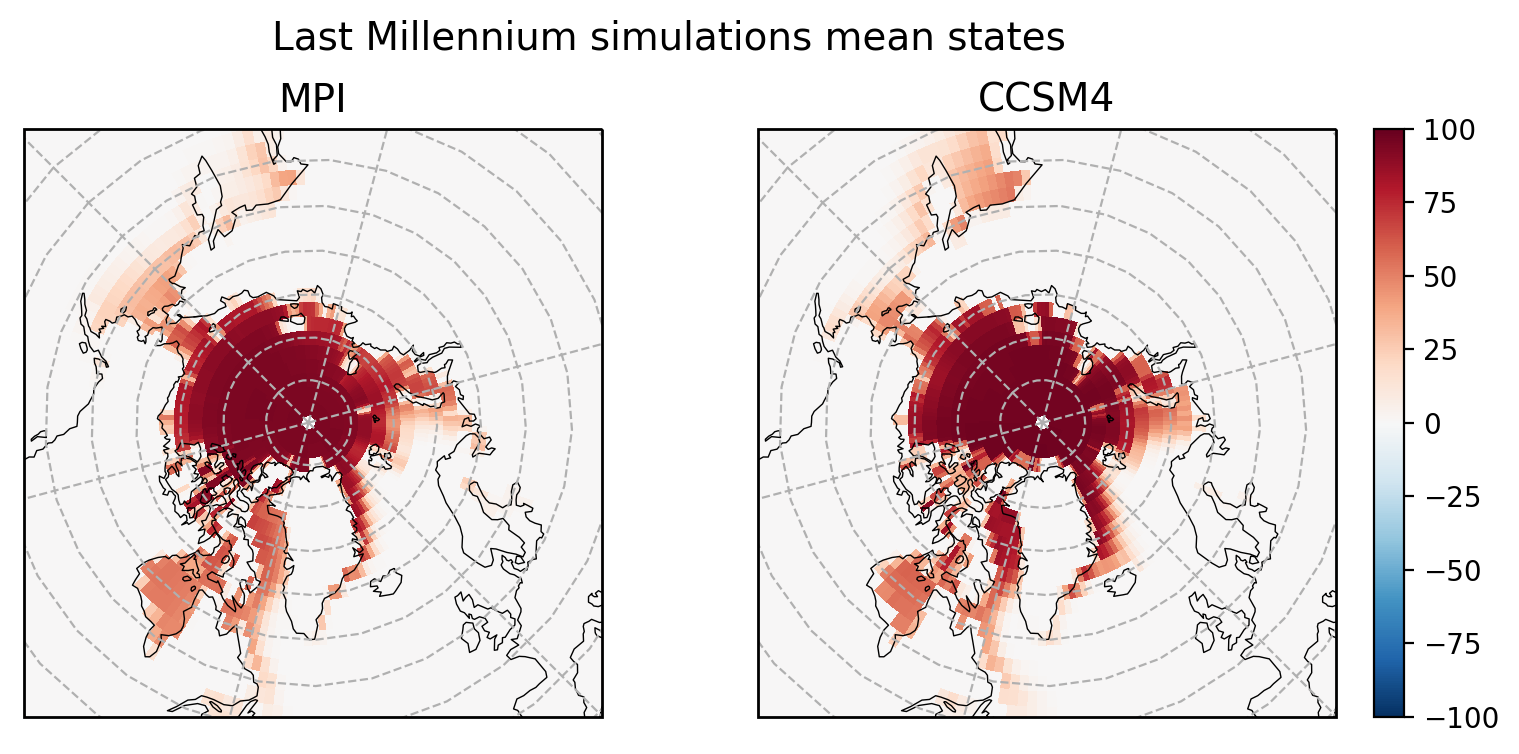

In [19]:
fig,ax = plt.subplots(1,2, figsize=(9, 4), subplot_kw = proj)

cs = sub_arctic_plot(fig,ax[0],mpi_sic_spatialmn,ccsm4_truth_lat[:,0],
                     ccsm4_truth_lon[0,:],'MPI',100)
cs = sub_arctic_plot(fig,ax[1],ccsm4_sic_spatialmn,ccsm4_truth_lat[:,0],
                     ccsm4_truth_lon[0,:],'CCSM4',100)

plt.colorbar(cs,ax=ax[1])

fig.suptitle('Last Millennium simulations mean states', fontsize=14,x=0.43)
plt.tight_layout(rect=(0,0.05,0.92,0.94))

savedir = ('/home/disk/p/mkb22/Documents/si_analysis_kb/common_era_experiments/'+
           'analysis/figures/Brennan_Hakim_2020/')
savename = 'Pseudo_arctic_sic_spatial_performance_recon_truth_r_CE.png'
#plt.savefig(savedir+savename)

/home/disk/chaos/mkb22/anaconda2/envs/lmr_py3_xarray/lib/python3.6/site-packages/cartopy/util.py:102: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  new_data = ma.concatenate((data, data[slicer]), axis=axis)


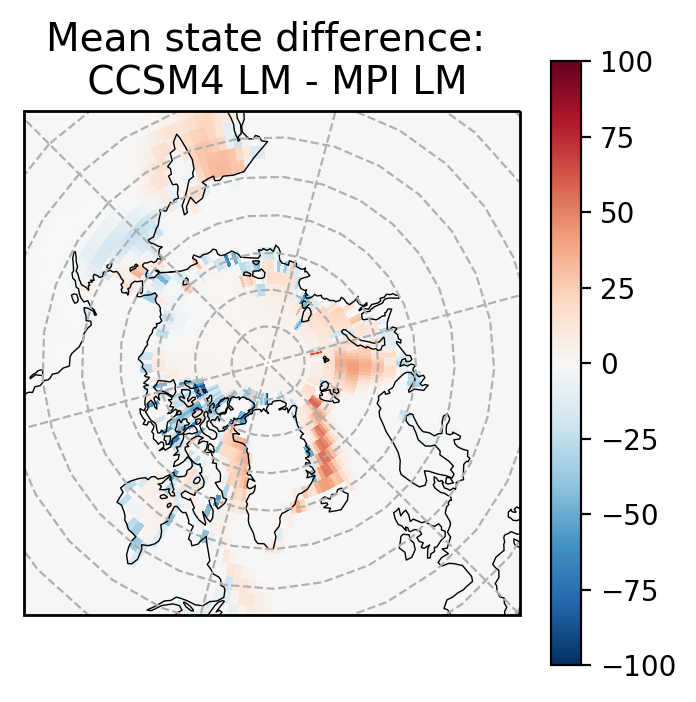

In [20]:
fig,ax = plt.subplots(1,1, figsize=(4, 4), subplot_kw = proj)

cs = sub_arctic_plot(fig,ax,ccsm4_sic_spatialmn - mpi_sic_spatialmn,
                     ccsm4_truth_lat[:,0],ccsm4_truth_lon[0,:],'Mean state difference: \n CCSM4 LM - MPI LM',100)

plt.colorbar(cs,ax=ax)

#fig.suptitle('Last Millennium simulations mean state difference', fontsize=14,x=0.43)
#plt.tight_layout(rect=(0,0.05,0.92,0.94))

savedir = ('/home/disk/p/mkb22/Documents/si_analysis_kb/common_era_experiments/'+
           'analysis/figures/Brennan_Hakim_2020/')
savename = 'CCSM4_minus_MPI_LM_mean_state_diff.png'
#plt.savefig(savedir+savename)

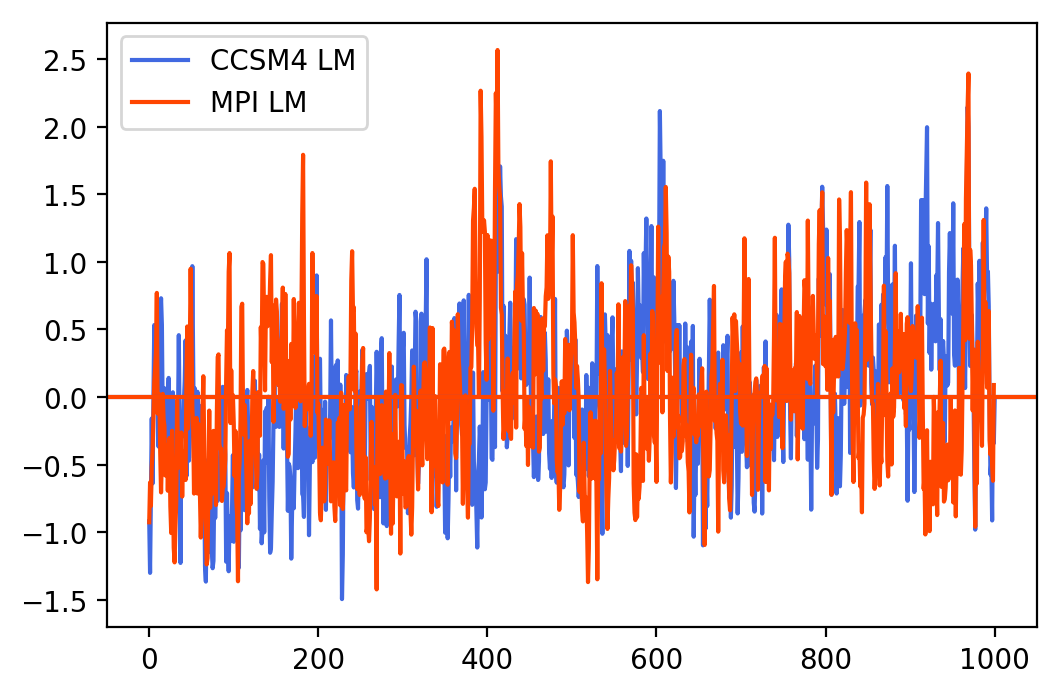

In [21]:
plt.plot(sie_nh_ccsm4_truth_anom, label='CCSM4 LM', color='royalblue')
plt.plot(sie_nh_mpi_anom, label='MPI LM', color='orangered')
plt.axhline(np.nanmean(sie_nh_ccsm4_truth_anom), color='royalblue')
plt.axhline(np.nanmean(sie_nh_mpi_anom),color='orangered')
plt.legend()

### Load psedo experiments, R = Pages2kv2 values: 

In [23]:
output_dir_ccsm4 = '/home/disk/p/mkb22/nobackup/LMR_output/common_era_experiments/experiments/pseudo/'
output_file_ccsm4 = 'sic_sit_ccsm4_anrecon_850_1850_pseudo_inf1_loc15000_Rpages2kv2_iter0.pkl'
niter = 10

[sic_lalo_allit, tas_lalo_allit, sic_ens_var_allit, 
 nobs_allit, obs_loc_allit, sia_Nens_allit, sie_Nens_allit, 
 sia_Sens_allit, sie_Sens_allit, Xb_inflate_allit, prox_lat, prox_lon, 
 recon_years, tas_truth_allit, sit_lalo_allit, sit_Nens_allit, 
 sit_Sens_allit] = ce_utils.load_sit_pseudo_recon_allit(output_dir_ccsm4,output_file_ccsm4,niter)

In [25]:
output_dir_ccsm4 = '/home/disk/p/mkb22/nobackup/LMR_output/common_era_experiments/experiments/pseudo/'
#output_file_ccsm4 = 'sic_sit_ccsm4_anrecon_850_1850_pseudo_inf2_6_loc15000_Rpages2kv2_iter0.pkl'
output_file_ccsm4 = 'sic_ccsm4_anrecon_850_1850_pseudo_inf1_loc15000_R0_4_iter0.pkl'

niter = 1

[sic_lalo_allit_inf, tas_lalo_allit_inf, sic_ens_var_allit_inf, 
 nobs_allit_inf, obs_loc_allit_inf, sia_Nens_allit_inf, sie_Nens_allit_inf, 
 sia_Sens_allit_inf, sie_Sens_allit_inf, Xb_inflate_allit_inf, prox_lat_inf, prox_lon_inf, 
 recon_years_inf, tas_truth_allit_inf] = ce_utils.load_pseudo_recon_allit(output_dir_ccsm4,output_file_ccsm4,niter)

In [26]:
Xb_allit_tas = Xb_inflate_allit[0:91*180,:,:]
Xb_allit_sic = Xb_inflate_allit[91*180:91*180*2,:,:]
Xb_allit_sit = Xb_inflate_allit[91*180*2:91*180*3,:,:]

In [ ]:
Xb_allit_sic_2d = np.reshape(Xb_allit_sic,(91*180,2000))

In [ ]:
np.ones((91,180))

In [27]:
pseudo_prox_map = np.ones((91,180))*np.nan
yr_int = 1800

for nprox in range(prox_lat_inf[yr_int].shape[0]):
    hold = np.abs(ccsm4_truth_lat[:,0]-prox_lat_inf[yr_int][nprox])
    hold2 = np.abs(ccsm4_truth_lon[0,:]-prox_lon_inf[yr_int][nprox])
    lat_hold = np.where(np.isclose(hold,hold.min(),atol=10e-3))
    lon_hold = np.where(np.isclose(hold2,hold2.min(),atol=10e-3))
    pseudo_prox_map[lat_hold,lon_hold] = ccsm4_truth_tas[yr_int-850,lat_hold,lon_hold]+273

KeyError: 1800

In [ ]:
prox_lat_inf[1800][0], ccsm4_truth_lat[64:67,0]

/home/disk/chaos/mkb22/anaconda2/envs/lmr_py3_xarray/lib/python3.6/site-packages/cartopy/util.py:102: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  new_data = ma.concatenate((data, data[slicer]), axis=axis)


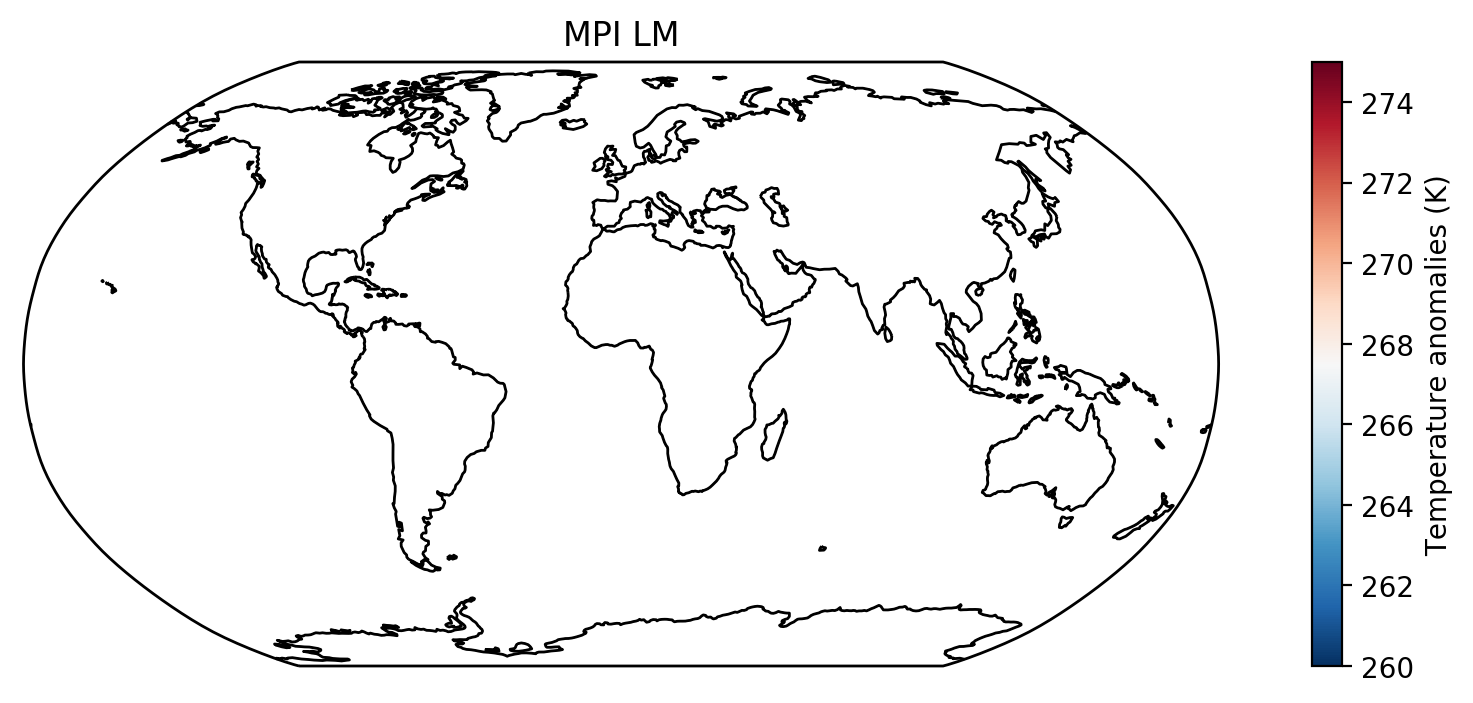

In [28]:
title = 'MPI LM'

global_spatial_plot(seudo_prox_map, ccsm4_truth_lat[:,0], 
                    ccsm4_truth_lon[0,:], 0, np.zeros((91,180)),title, 
                    'Temperature anomalies (K)',260, 275)

In [ ]:
((ccsm4_truth_tas[yr_int-850,:,:])+273).min()

In [ ]:
title = 'CCSM4 LM'

global_spatial_plot((ccsm4_truth_tas[yr_int-850,:,:])+273, ccsm4_truth_lat[:,0], 
                    ccsm4_truth_lon[0,:], 0, np.zeros((91,180)),title, 
                    'Temperature anomalies (K)',260, 275)

In [ ]:
ccsm4_truth_lon[0,:]

## Northern Hemisphere skill: 

In [29]:
sie_Nens_allit_2d = np.reshape(sie_Nens_allit,
                               (sie_Nens_allit.shape[0],
                                sie_Nens_allit.shape[1]*sie_Nens_allit.shape[2]))

sie_ens_anom_allit = sie_Nens_allit_2d - np.nanmean(sie_Nens_allit_2d,axis=0)
sie_ccsm4_recon_anom = np.mean(sie_ens_anom_allit,axis=1)

sie_recon_97_5_anom = np.percentile(sie_ens_anom_allit,97.5,axis=1)
sie_recon_2_5_anom = np.percentile(sie_ens_anom_allit,2.5,axis=1)

In [30]:
sie_Nens_allit_inf_2d = np.reshape(sie_Nens_allit_inf,
                               (sie_Nens_allit_inf.shape[0],
                                sie_Nens_allit_inf.shape[1]*sie_Nens_allit_inf.shape[2]))

sie_ens_anom_allit_inf = sie_Nens_allit_inf_2d - np.nanmean(sie_Nens_allit_inf_2d,axis=0)
sie_ccsm4_recon_anom_inf = np.mean(sie_ens_anom_allit_inf,axis=1)

sie_recon_97_5_anom_inf = np.percentile(sie_ens_anom_allit_inf,97.5,axis=1)
sie_recon_2_5_anom_inf = np.percentile(sie_ens_anom_allit_inf,2.5,axis=1)

In [31]:
yr = 850
[ce_tot,corr_tot,_,_] = rrutils.find_ce_corr(sie_ccsm4_recon_anom,
                                             sie_nh_ccsm4_truth_anom, 
                                             ccsm4_truth_time[it_truth],
                                             np.array(recon_years),
                                             yr,1849)

In [32]:
[ce_tot_inf,corr_tot_inf,_,_] = rrutils.find_ce_corr(sie_ccsm4_recon_anom_inf,
                                                     sie_nh_ccsm4_truth_anom, 
                                                     ccsm4_truth_time[it_truth],
                                                     np.array(recon_years_inf),
                                                     yr,1849)

print('CE (850-1850)          = '+str(ce_tot))
print('CE inflated (850-1850) = '+str(ce_tot_inf))
print('R^2 (850-1850)          = '+str(corr_tot**2))
print('R^2 inflated (850-1850) = '+str(corr_tot_inf**2))

CE (850-1850)          = 0.4688759738326348
CE inflated (850-1850) = 0.42601595829268346
R^2 (850-1850)          = 0.5082954986007273
R^2 inflated (850-1850) = 0.434936949177819


In [33]:
print('Var(CCSM4 LM)  = ',np.var(sie_nh_ccsm4_truth_anom))
print('Var(inf recon) = ',np.var(sie_ccsm4_recon_anom_inf))
print('Var(recon)     = ',np.var(sie_ccsm4_recon_anom))

Var(CCSM4 LM)  =  0.32535502131094285
Var(inf recon) =  0.10398225618695395
Var(recon)     =  0.0861789348952996


In [ ]:
# plt.plot(sie_ccsm4_recon_anom)
# plt.plot(sie_nh_ccsm4_truth_anom)

In [34]:
seg_length =500
ce_sie_pseudo = []
corr_sie_pseudo = []

for yr in range(recon_years[0],recon_years[-1]-seg_length+1): 
#    print(str(yr))
    [ce_seg,
     corr_seg,_,_] = rrutils.find_ce_corr(sie_ccsm4_recon_anom,
                                          sie_nh_ccsm4_truth_anom, 
                                          ccsm4_truth_time[it_truth],
                                          np.array(recon_years),
                                          yr,yr+seg_length)

    ce_sie_pseudo = np.append(ce_sie_pseudo,ce_seg)
    corr_sie_pseudo = np.append(corr_sie_pseudo,corr_seg)

In [35]:
corr_sie_pseudo[0]**2

0.31311894011398217

Text(0.5,1,'Skill in time: 500 year segments')

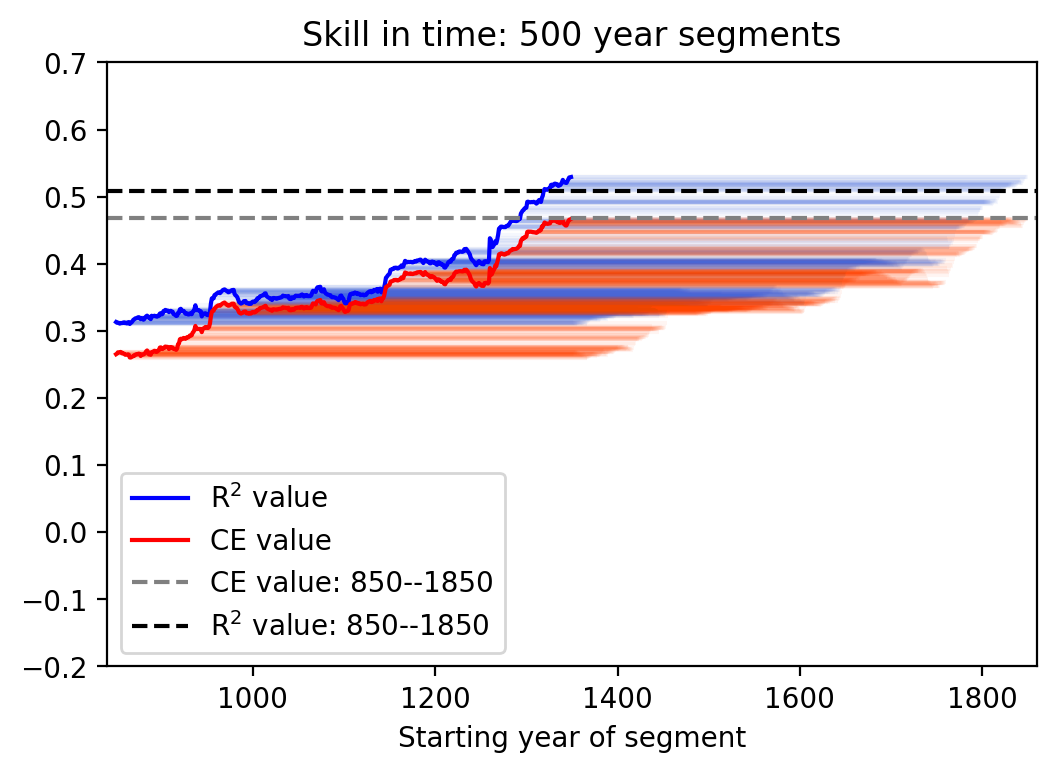

In [36]:
for i in range(corr_sie_pseudo.shape[0]): 
    plt.hlines(corr_sie_pseudo[i]**2,recon_years[i],recon_years[i]+seg_length+1,color='royalblue',alpha=0.05)
    plt.hlines(ce_sie_pseudo[i],recon_years[i],recon_years[i]+seg_length+1,color='orangered',alpha=0.05)

plt.plot(range(recon_years[0],recon_years[-1]-seg_length+1),corr_sie_pseudo**2, 
         label='R$^2$ value',color='blue')
plt.plot(range(recon_years[0],recon_years[-1]-seg_length+1),ce_sie_pseudo, 
         label='CE value',color='red')        
        
plt.axhline(ce_tot,linestyle='--',color='gray',label='CE value: 850--1850')
plt.axhline(corr_tot**2,linestyle='--',color='k',label='R$^2$ value: 850--1850')
#plt.axhline(ce_tot,linestyle='--',color='orangered',label='CE value: 850--1850')

plt.xlim(840,1860)
plt.ylim(-0.2,0.7)
plt.xlabel('Starting year of segment')
plt.legend(fontsize=10)
plt.title('Skill in time: '+str(seg_length)+' year segments')

In [ ]:
#MSE = np.mean(((sie_nh_ccsm4_truth_anom[:-1,np.newaxis] - sie_ens_anom_allit)**2),axis=1)

# Wn2 = 1.0/30
# nf2 = 7
# b2,a2 = signal.butter(nf2,Wn2,btype='lowpass')
# w2, h2 = signal.freqs(b2, a2)
# MSE_filt20 = signal.filtfilt(b2,a2,MSE)

In [ ]:
# plt.plot(recon_years,MSE,label='MSE',color='k',linewidth=1, alpha=0.7)    
# plt.plot(recon_years,MSE_filt20,label='MSE - 30 year filter',color='salmon', linewidth=2)    

# plt.grid(linestyle='--', axis='y', which='major')
# plt.yticks(np.arange(0,2.1,0.5))

# plt.xlim(840,1860)
# plt.ylim(0,2)
# plt.xlabel('Year (CE)')
# plt.ylabel('(10$^{6}$ $km^2$)$^2$')
# plt.legend(fontsize=10)
# plt.title('Perfect Model Experiment',fontsize=12)

In [ ]:
print('Stdev(truth)= '+str(np.std(sie_nh_ccsm4_truth_anom)))
print('Stdev(recon)= '+str(np.std(sie_ccsm4_recon_anom)))

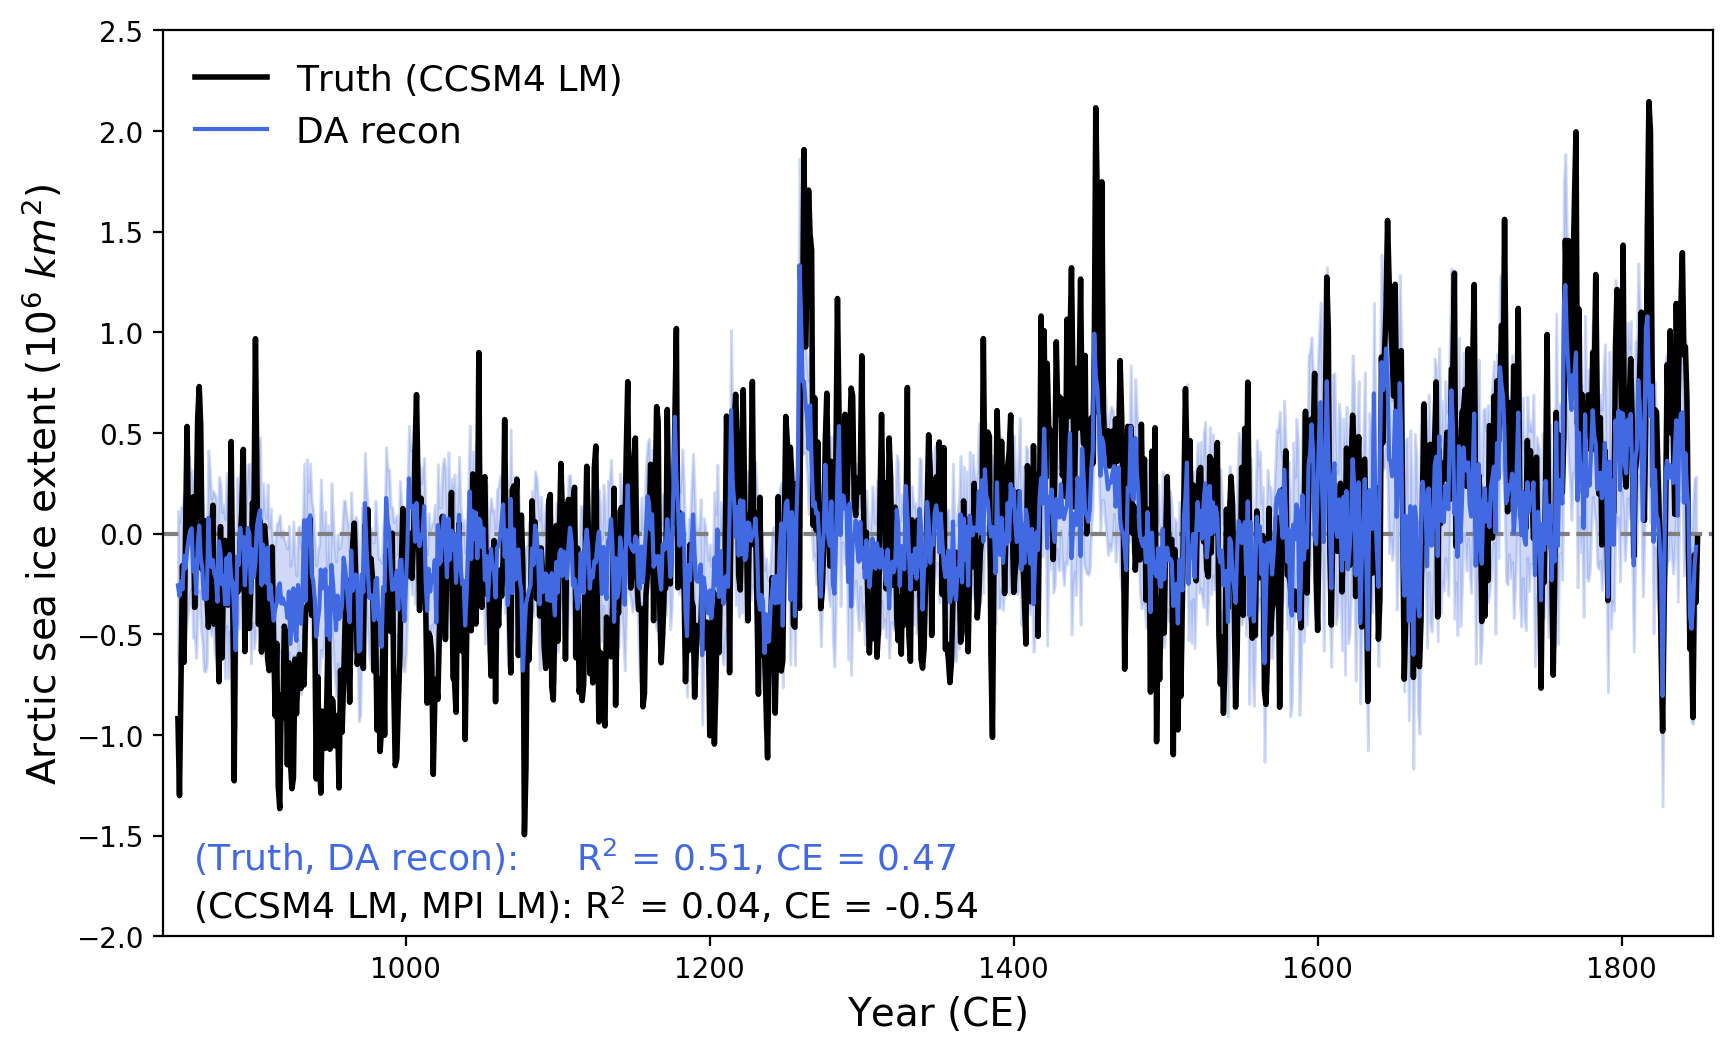

In [37]:
plt.figure(figsize=(10,6))
plt.axhline(0,linestyle='--',color='grey')

# plt.plot(mpi_time[it_mpi],sie_nh_mpi_anom, label='MPI LM',
#          color='gray',linewidth=1, linestyle ='--')
plt.plot(ccsm4_truth_time[it_truth],sie_nh_ccsm4_truth_anom, label='Truth (CCSM4 LM)',
         color='k',linewidth=2)
plt.plot(recon_years,sie_ccsm4_recon_anom, label = 'DA recon',
         color='royalblue',linewidth=1.5)
# plt.plot(recon_years_inf,sie_ccsm4_recon_anom_inf, label = 'DA recon - inflated',
#          color='c',linewidth=1)

plt.fill_between(recon_years,sie_recon_2_5_anom,sie_recon_97_5_anom,
                 color='royalblue',alpha=0.25)
# plt.fill_between(recon_years,sie_recon_2_5_anom_inf,sie_recon_97_5_anom_inf,
#                  color='c',alpha=0.15)

plt.ylabel('Arctic sea ice extent (10$^{6}$ $km^2$)',fontsize=14)
plt.xlabel('Year (CE)',fontsize=14)
#plt.title('Total Arctic Sea Ice Extent', fontsize=14)

plt.legend(fontsize=13,loc='upper left',frameon=False)#,bbox_to_anchor=(0.81, 0.22),frameon=False)
plt.ylim(-3,4,1)
ce_corr_plt_ccsm4 = (('(Truth, DA recon):     R$^2$ = ' + 
                      '{:,.2f}'.format(corr_tot**2))+
                     ', CE = '+'{:,.2f}'.format(ce_tot))
ce_corr_plt_ccsm4_inf = (('(Truth, DA recon):     R$^2$ = ' + 
                      '{:,.2f}'.format(corr_tot_inf**2))+
                     ', CE = '+'{:,.2f}'.format(ce_tot_inf))
ce_corr_plt_mod = (('(CCSM4 LM, MPI LM): R$^2$ = ' + 
                      '{:,.2f}'.format(corr_sie_mod**2))+
                     ', CE = '+'{:,.2f}'.format(ce_sie_mod))

plt.gcf().text(0.14, 0.14, ce_corr_plt_mod , fontsize=13,color='k')
#plt.gcf().text(0.14, 0.22, ce_corr_plt_ccsm4_inf , fontsize=13,color='c')
plt.gcf().text(0.14, 0.18, ce_corr_plt_ccsm4 , fontsize=13,color='royalblue')

plt.xlim(840,1860)
plt.ylim(-2,2.5)

savedir = ('/home/disk/p/mkb22/Documents/si_analysis_kb/common_era_experiments/'+
           'analysis/figures/Brennan_Hakim_2020/')
savename = 'Pseudo_arctic_sie_timeseries_performance_recon_850_1850_truth.png'
#plt.savefig(savedir+savename)

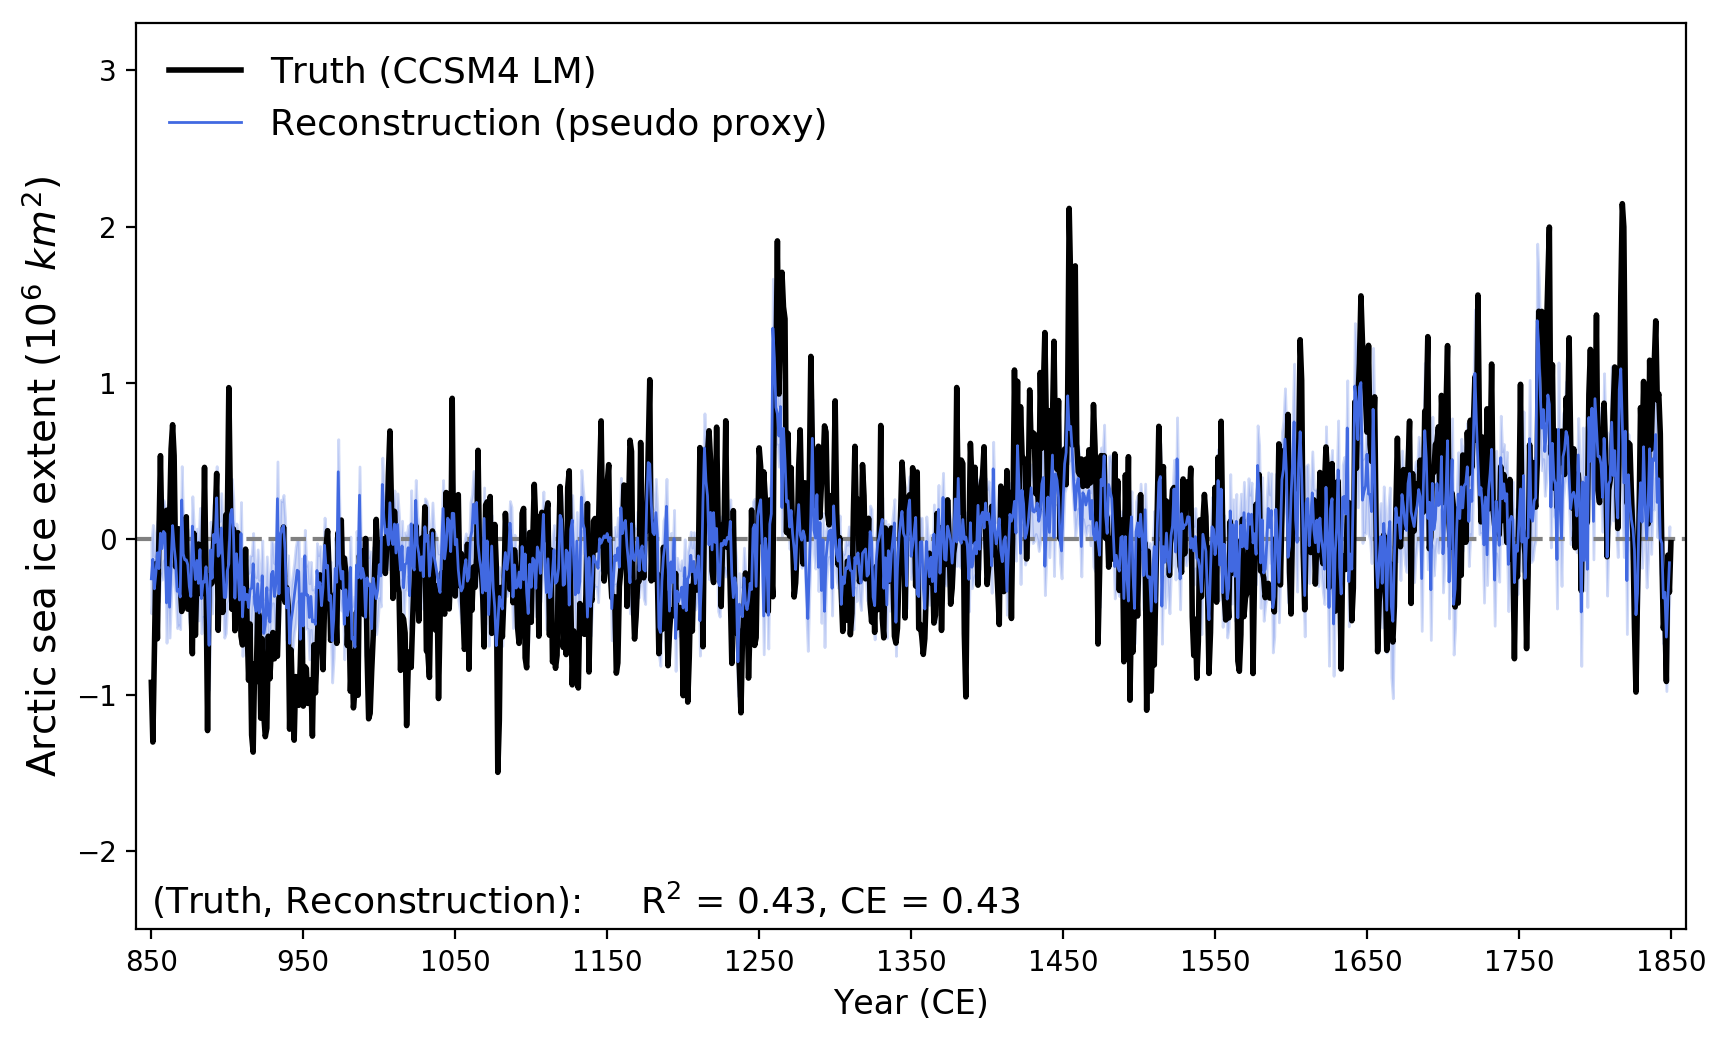

In [42]:
fig,ax = plt.subplots(1,1, figsize=(10, 6))


plot_pseudo_tm_validation(ax, ccsm4_truth_time[it_truth],sie_nh_ccsm4_truth_anom, recon_years,
                          sie_ccsm4_recon_anom_inf, sie_recon_2_5_anom_inf,sie_recon_97_5_anom_inf,
                          corr_tot_inf, ce_tot_inf, corr_sie_mod, ce_sie_mod, -2.5,3.3)

In [39]:
def plot_pseudo_tm_validation(ax, time, truth, recon_time, recon, recon_2_5, recon_97_5, 
                              corr_tot, ce_tot, corr_sie_mod, ce_sie_mod, min, max):
    ax.axhline(0,linestyle='--',color='grey')

    ax.plot(time, truth, label='Truth (CCSM4 LM)',color='k',linewidth=2)
    ax.plot(recon_time, recon, label = 'Reconstruction (pseudo proxy)',color='royalblue',linewidth=1.0)

    ax.fill_between(recon_time,recon_2_5,recon_97_5,color='royalblue',alpha=0.25)

    ax.set_ylabel('Arctic sea ice extent (10$^{6}$ $km^2$)',fontsize=14)
    ax.set_xlabel('Year (CE)',fontsize=12)
    #plt.title('Total Arctic Sea Ice Extent', fontsize=14)
    
    ax.set_xticks(np.arange(850,1851,100))

    ax.legend(fontsize=13,loc='upper left',frameon=False)#,bbox_to_anchor=(0.81, 0.22),frameon=False)
    ax.set_ylim(-3,4,1)
    
    ce_corr_plt_ccsm4 = (('(Truth, Reconstruction):     R$^2$ = ' + 
                          '{:,.2f}'.format(corr_tot**2))+
                         ', CE = '+'{:,.2f}'.format(ce_tot))
    ce_corr_plt_mod = (('(CCSM4 LM, MPI LM): R$^2$ = ' + 
                          '{:,.2f}'.format(corr_sie_mod**2))+
                         ', CE = '+'{:,.2f}'.format(ce_sie_mod))

#     plt.gcf().text(0.14, 0.14, ce_corr_plt_mod , fontsize=13,color='k')
#     plt.gcf().text(0.14, 0.18, ce_corr_plt_ccsm4 , fontsize=13,color='royalblue')
#    ax.text(850, -2.0, ce_corr_plt_mod , fontsize=13,color='k')
    ax.text(850, -2.4, ce_corr_plt_ccsm4 , fontsize=13,color='k')

    ax.set_xlim(840,1860)
    ax.set_ylim(min,max)

In [ ]:
ce_corr_plt_ccsm4 

In [ ]:
plt.plot(recon_years, nobs_allit)
plt.ylabel('Number of proxies assimilated')

## Southern Hemisphere skill: 

In [ ]:
sie_Sens_allit_2d = np.reshape(sie_Sens_allit,
                               (sie_Sens_allit.shape[0],
                                sie_Sens_allit.shape[1]*sie_Sens_allit.shape[2]))
sie_Sens_allit_anom = sie_Sens_allit_2d - np.nanmean(sie_Sens_allit_2d,axis=0)
sie_ccsm4_recon_anom = np.nanmean(sie_Sens_allit_anom,axis=1)

sie_recon_97_5_anom = np.percentile(sie_Sens_allit_anom,97.5,axis=1)
sie_recon_2_5_anom = np.percentile(sie_Sens_allit_anom,2.5,axis=1)

In [ ]:
[ce_sie_mod,
 corr_sie_mod,_,_] = rrutils.find_ce_corr(sie_sh_ccsm4_truth_anom, 
                                          sie_sh_mpi_anom,
                                          mpi_time[it_mpi],
                                          ccsm4_truth_time[it_truth],
                                          recon_start, recon_end)

corr_sie_mod**2,ce_sie_mod

In [ ]:
[ce_sie_pseudo,
 corr_sie_pseudo,_,_] = rrutils.find_ce_corr(sie_sh_ccsm4_truth_anom, 
                                             sie_ccsm4_recon_anom,
                                             np.array(recon_years),
                                             ccsm4_truth_time[it_truth],
                                             recon_start,recon_end)

corr_sie_pseudo,ce_sie_pseudo

In [ ]:
plt.figure(figsize=(10,6))
plt.axhline(0,linestyle='--',color='grey')

plt.plot(mpi_time[it_mpi],sie_sh_mpi_anom, label='truth (MPI LM)',
         color='k',linewidth=2)
plt.plot(ccsm4_truth_time[it_truth],sie_sh_ccsm4_truth_anom, label='CCSM4 LM',
         color='gray',linewidth=1, linestyle ='--')
plt.plot(recon_years,sie_ccsm4_recon_anom, label = 'DA recon',
         color='royalblue',linewidth=1.5)

plt.fill_between(recon_years,sie_recon_2_5_anom,sie_recon_97_5_anom,
                 color='royalblue',alpha=0.25)

plt.ylabel('Antarctic sea ice extent anomalies (10$^{6}$ $km^2$)',fontsize=14)
plt.xlabel('Year (CE)',fontsize=14)
#plt.title('Total Arctic Sea Ice Extent', fontsize=14)

plt.legend(fontsize=13,loc='upper left',frameon=False)#,bbox_to_anchor=(0.81, 0.22),frameon=False)
plt.ylim(-5,6,1)
ce_corr_plt_ccsm4 = (('(Truth, DA recon):     R = ' + 
                      '{:,.2f}'.format(corr_sie_pseudo))+
                     ', CE = '+'{:,.2f}'.format(ce_sie_pseudo))
ce_corr_plt_mod = (('(CCSM4 LM, MPI LM): R = ' + 
                      '{:,.2f}'.format(corr_sie_mod))+
                     ', CE = '+'{:,.2f}'.format(ce_sie_mod))

plt.gcf().text(0.14, 0.14, ce_corr_plt_mod , fontsize=13,color='k')
plt.gcf().text(0.14, 0.18, ce_corr_plt_ccsm4 , fontsize=13,color='k')

plt.xlim(840,1860)

savedir = ('/home/disk/p/mkb22/Documents/si_analysis_kb/common_era_experiments/'+
           'analysis/figures/Brennan_Hakim_2020/')
savename = 'Pseudo_antarctic_sie_timeseries_performance_recon_850_1850_truth.png'
#plt.savefig(savedir+savename)

#### Load proxy locations for plotting: 

In [40]:
proxinfo_loc = ('/home/disk/p/mkb22/nobackup/LMR_output/common_era_experiments/'+
            'experiments/pseudo/pages2kv2_all_proxy_info.pkl')

prox_loc_info = pickle.load(open(proxinfo_loc,'rb'))

In [41]:
proxy_types = ['Tree Rings_WidthPages2', 'Tree Rings_WoodDensity', 
               'Ice Cores_d18O', 'Ice Cores_dD', 
               'Ice Cores_MeltFeature', 'Lake Cores_Varve',
               'Lake Cores_Misc']

### Spatial validation: SIT

In [ ]:
sit_shape = sit_lalo_allit.shape
sit_shape_true = ccsm4_truth_sit.shape
sit_lalo_ensmn = np.nanmean(sit_lalo_allit,axis=3)

sit_recon_2d = np.reshape(sit_lalo_ensmn,(sit_shape[0],sit_shape[1]*sit_shape[2]))
sit_truth_2d = np.reshape(ccsm4_truth_sit,(sit_shape_true[0],sit_shape_true[1]*sit_shape_true[2]))
sit_truth_2d = np.squeeze(sit_truth_2d[it_truth,:])[:-1]

In [ ]:
r_sit = np.zeros(sit_truth_2d.shape[1])
r2_sit = np.zeros(sit_truth_2d.shape[1])
ce_sit = np.zeros(sit_truth_2d.shape[1])

for lalo in range(sit_truth_2d.shape[1]):
    r_sit[lalo],r2_sit[lalo],_ = kbstats.corr_timeseries(sit_truth_2d[:,lalo],sit_recon_2d[:,lalo])
    ce_sit[lalo]= kbstats.coefficient_efficiency(sit_truth_2d[:,lalo],sit_recon_2d[:,lalo])

In [ ]:
r_sit = np.reshape(r_sit,(sit_shape_true[1],sit_shape_true[2]))
ce_sit = np.reshape(ce_sit,(sit_shape_true[1],sit_shape_true[2]))

fig,ax = plt.subplots(1,2, figsize=(9, 4), subplot_kw = proj)

cs = sub_arctic_plot(fig,ax[0],r_sit,ccsm4_truth_lat[:,0],ccsm4_truth_lon[0,:],'Correlation',1)
cs = sub_arctic_plot(fig,ax[1],ce_sit,ccsm4_truth_lat[:,0],ccsm4_truth_lon[0,:],'Coefficient of Efficiency',1)

for ptype in proxy_types: 
    ax[0].scatter([prox_loc_info[ptype]['lon']],[prox_loc_info[ptype]['lat']],
                   color='grey',transform=ccrs.PlateCarree(), 
                   label=prox_loc_info[ptype]['label'], marker='o',
                  edgecolors='k',s=15)
    ax[1].scatter([prox_loc_info[ptype]['lon']],[prox_loc_info[ptype]['lat']],
                   color='grey',transform=ccrs.PlateCarree(), 
                   label=prox_loc_info[ptype]['label'], marker='o',
                  edgecolors='k',s=15)
    
handle_list = []
label_list = []
handles, labels = ax[0].get_legend_handles_labels()
for handle, label in zip(handles, labels):
    if label not in label_list:
        handle_list.append(handle)
        label_list.append(label)

#fig.legend(handle_list, label_list, ncol=3,loc='lower center')#bbox_to_anchor=(0.5, 0.0),)

plt.colorbar(cs,ax=ax[1])

fig.suptitle('Sea ice thickness: Truth vs Reconstruction', fontsize=14,x=0.43)
plt.tight_layout(rect=(0,0.05,0.92,0.94))
#plt.subplots_adjust(wspace=0, hspace=0.1)
#plt.scatter(100, 10, color='m')

savedir = ('/home/disk/p/mkb22/Documents/si_analysis_kb/common_era_experiments/'+
           'analysis/figures/Brennan_Hakim_2020/')
savename = 'Pseudo_arctic_sit_spatial_performance_recon_850_1850_truth_r_CE.png'
#plt.savefig(savedir+savename)

### Spatial validation: SIC

In [36]:
sic_shape = sic_lalo_allit.shape
sic_shape_true = ccsm4_truth_sic.shape

sic_lalo_ensmn = np.nanmean(sic_lalo_allit,axis=3)
sic_truth_lalo = np.squeeze(ccsm4_truth_sic[it_truth,:,:])[:-1]
sic_2_5_lalo = np.percentile(sic_lalo_allit,2.5,axis=3)
sic_97_5_lalo = np.percentile(sic_lalo_allit,97.5,axis=3)

sic_prior_ensmn = np.reshape(np.nanmean(Xb_inflate_allit[91*180:91*180*2],axis=2).T,(200,91,180))

sic_recon_2d = np.reshape(sic_lalo_ensmn,(sic_shape[0],sic_shape[1]*sic_shape[2]))
sic_truth_2d = np.reshape(ccsm4_truth_sic,(sic_shape_true[0],sic_shape_true[1]*sic_shape_true[2]))
sic_truth_2d = np.squeeze(sic_truth_2d[it_truth,:])[:-1]

In [37]:
ccsm4_truth_sic.shape

(1001, 91, 180)

In [38]:
r_sic = np.zeros(sic_truth_2d.shape[1])
r2_sic = np.zeros(sic_truth_2d.shape[1])
ce_sic = np.zeros(sic_truth_2d.shape[1])

for lalo in range(sic_truth_2d.shape[1]):
    r_sic[lalo],r2_sic[lalo],_ = kbstats.corr_timeseries(sic_truth_2d[:,lalo],sic_recon_2d[:,lalo])
    ce_sic[lalo]= kbstats.coefficient_efficiency(sic_truth_2d[:,lalo],sic_recon_2d[:,lalo])

/home/disk/p/mkb22/Documents/si_utils_kb/stats_utils.py:64: RuntimeWarning: invalid value encountered in double_scalars
  X_Y_corr = covariance(X,Y)/(X_stdev*Y_stdev)
/home/disk/p/mkb22/Documents/si_utils_kb/stats_utils.py:65: RuntimeWarning: invalid value encountered in double_scalars
  X_Y_reg = covariance(X,Y)/(X_stdev**2)
/home/disk/p/mkb22/Documents/si_utils_kb/stats_utils.py:177: RuntimeWarning: invalid value encountered in true_divide
  CE    = 1. - np.divide(numer,denom)


In [ ]:
# r_thresh = np.where(r_sic>np.sqrt(0.4),1.0,0.0)
# ce_thresh = np.where(ce_sic>np.sqrt(0.4),1.0,0.0)
# ax[0].contourf(ccsm4_truth_lon[0,:], ccsm4_truth_lat[:,0], r_thresh, 
#                   levels = [0,0.5,1],hatches=['','...'], alpha=0,
#                   transform=ccrs.PlateCarree())
# ax[1].contourf(ccsm4_truth_lon[0,:], ccsm4_truth_lat[:,0], ce_thresh, 
#                   levels = [0,0.5,1],hatches=['','...'], alpha=0,
#                   transform=ccrs.PlateCarree())

# ax[0].scatter(obs_lon, obs_lat, facecolors='grey', s=15,
#               edgecolors='k', transform=ccrs.PlateCarree())
# ax[1].scatter(obs_lon, obs_lat, facecolors='grey',s=15,
#               edgecolors='k', transform=ccrs.PlateCarree())

/home/disk/chaos/mkb22/anaconda2/envs/lmr_py3_xarray_test/lib/python3.6/site-packages/cartopy/util.py:102: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  new_data = ma.concatenate((data, data[slicer]), axis=axis)


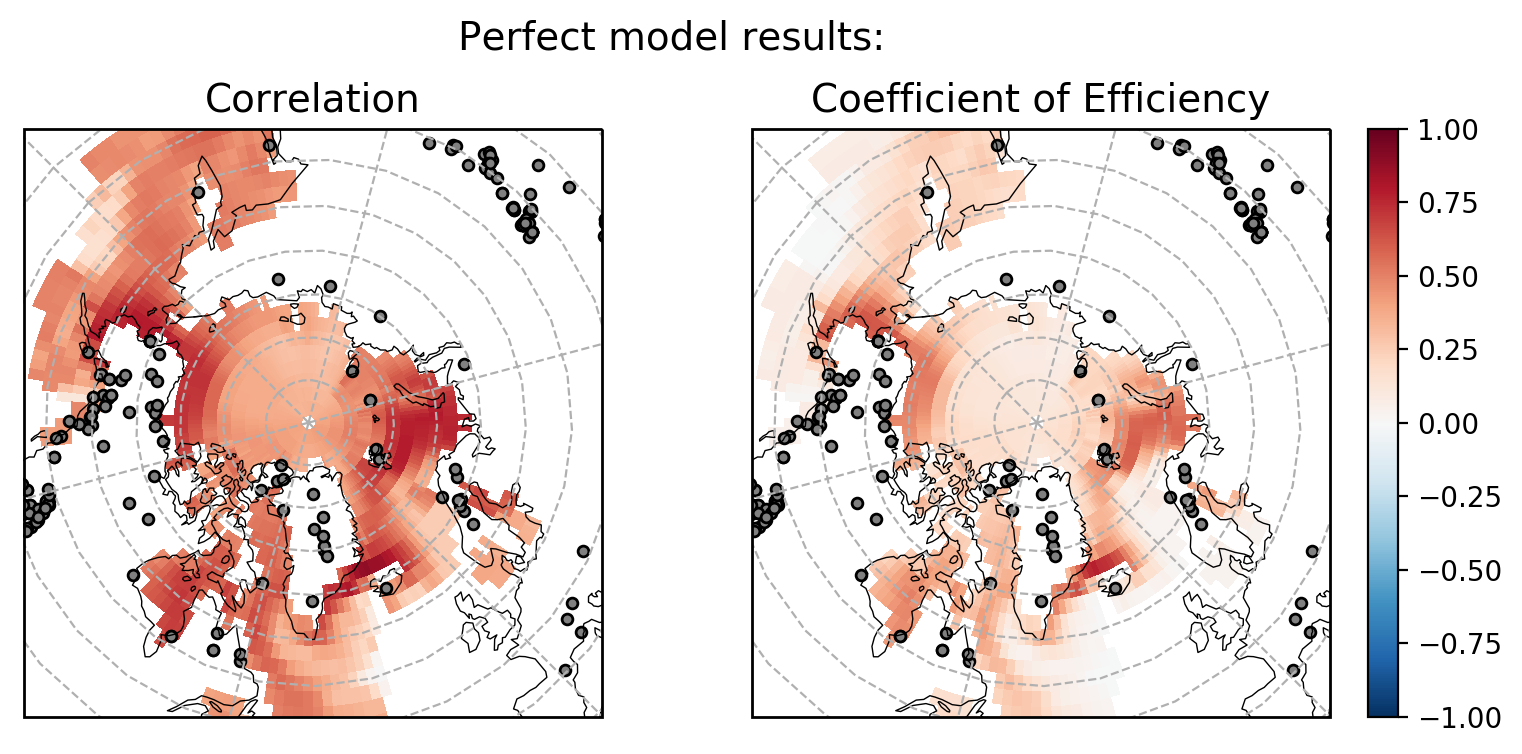

In [42]:
r_sic = np.reshape(r_sic,(sic_shape_true[1],sic_shape_true[2]))
ce_sic = np.reshape(ce_sic,(sic_shape_true[1],sic_shape_true[2]))

fig,ax = plt.subplots(1,2, figsize=(9, 4), subplot_kw = proj)

cs = sub_arctic_plot(fig,ax[0],r_sic,ccsm4_truth_lat[:,0],ccsm4_truth_lon[0,:],'Correlation',1)
cs = sub_arctic_plot(fig,ax[1],ce_sic,ccsm4_truth_lat[:,0],ccsm4_truth_lon[0,:],'Coefficient of Efficiency',1)

for ptype in proxy_types: 
    ax[0].scatter([prox_loc_info[ptype]['lon']],[prox_loc_info[ptype]['lat']],
                   color='grey',transform=ccrs.PlateCarree(), 
                   label=prox_loc_info[ptype]['label'], marker='o',
                  edgecolors='k',s=15)
    ax[1].scatter([prox_loc_info[ptype]['lon']],[prox_loc_info[ptype]['lat']],
                   color='grey',transform=ccrs.PlateCarree(), 
                   label=prox_loc_info[ptype]['label'], marker='o',
                  edgecolors='k',s=15)
    
handle_list = []
label_list = []
handles, labels = ax[0].get_legend_handles_labels()
for handle, label in zip(handles, labels):
    if label not in label_list:
        handle_list.append(handle)
        label_list.append(label)

#fig.legend(handle_list, label_list, ncol=3,loc='lower center')#bbox_to_anchor=(0.5, 0.0),)

plt.colorbar(cs,ax=ax[1])

fig.suptitle('Perfect model results:',fontsize=14,x=0.43)
plt.tight_layout(rect=(0,0.05,0.92,0.94))
#plt.subplots_adjust(wspace=0, hspace=0.1)
#plt.scatter(100, 10, color='m')

savedir = ('/home/disk/p/mkb22/Documents/si_analysis_kb/common_era_experiments/'+
           'analysis/figures/Brennan_Hakim_2020/')
savename = 'Pseudo_arctic_sic_spatial_performance_recon_850_1850_truth_r_CE.png'
#plt.savefig(savedir+savename)

/home/disk/chaos/mkb22/anaconda2/envs/lmr_py3_xarray_test/lib/python3.6/site-packages/cartopy/util.py:102: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  new_data = ma.concatenate((data, data[slicer]), axis=axis)


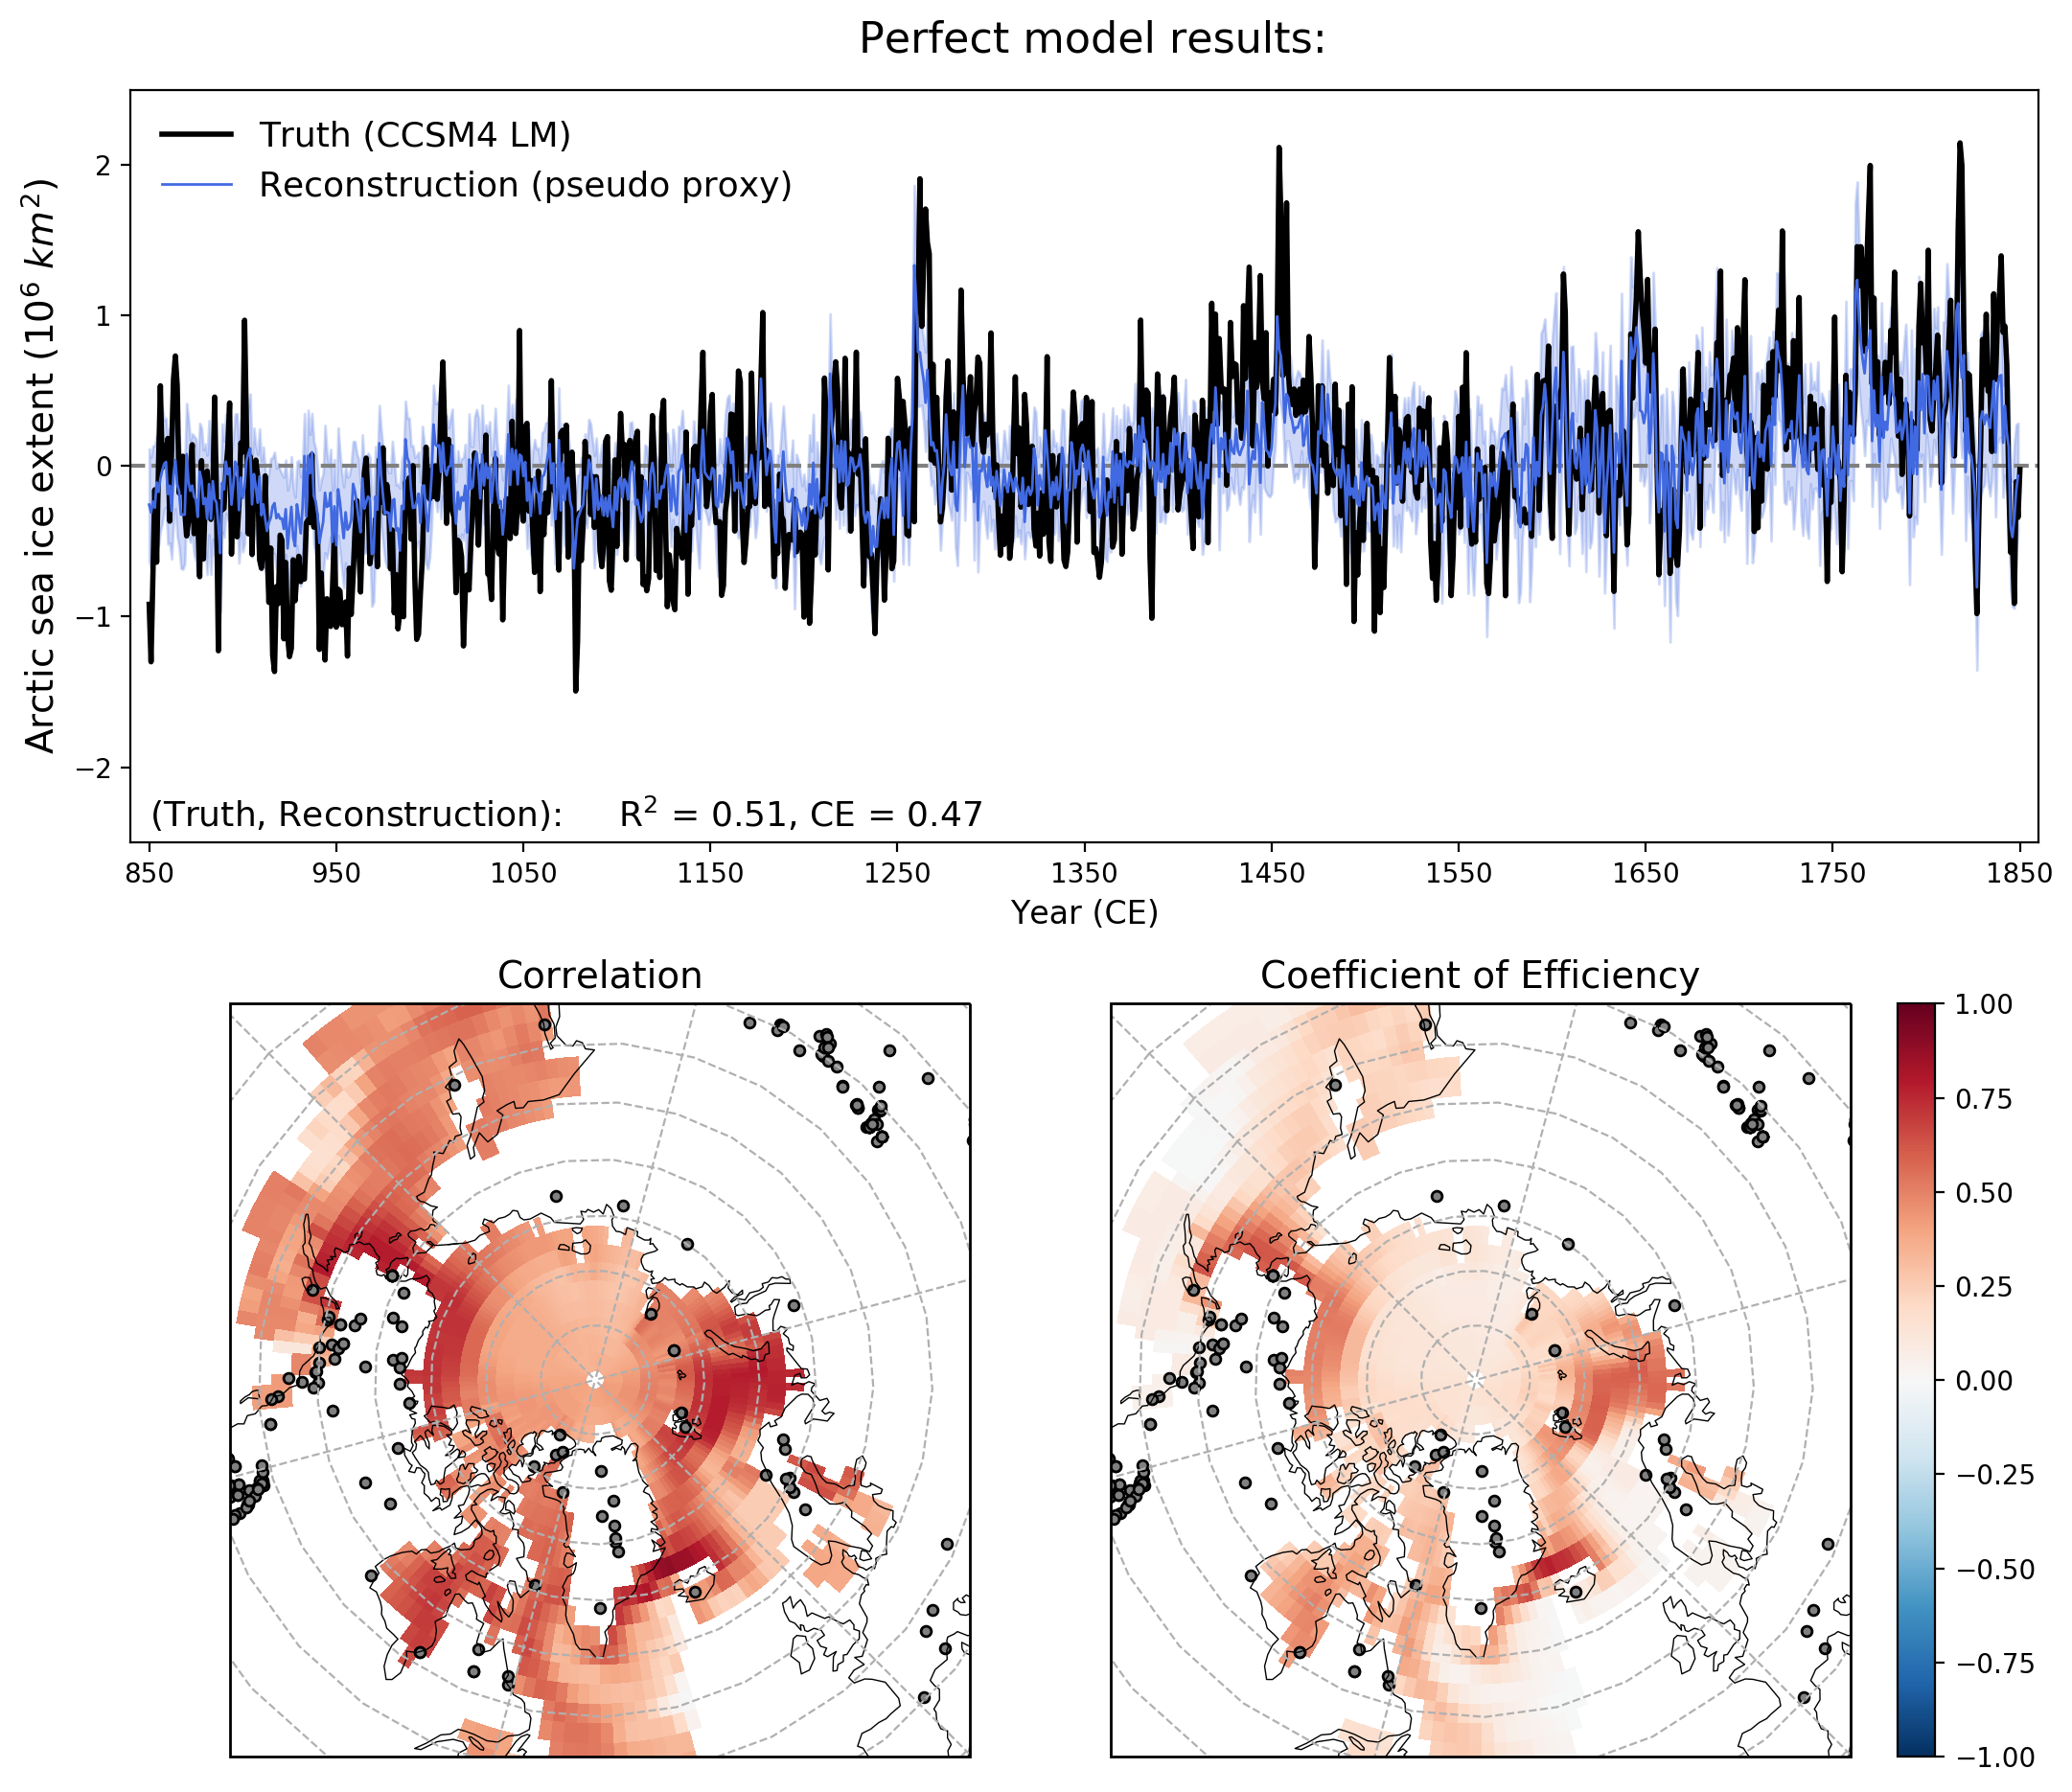

In [44]:
import matplotlib.gridspec as gridspec

fig= plt.figure(figsize=(11.5, 10))

gs = gridspec.GridSpec(2,2, figure=fig)

ax0 = fig.add_subplot(gs[0, :])
ax1 = fig.add_subplot(gs[-1, 0], projection = ccrs.Stereographic(central_latitude=90,
                                                                 central_longitude=-45,
                                                                 true_scale_latitude=0.1))
ax2 = fig.add_subplot(gs[-1, -1], projection = ccrs.Stereographic(central_latitude=90,
                                                                 central_longitude=-45,
                                                                 true_scale_latitude=0.1))

plot_pseudo_tm_validation(ax0, ccsm4_truth_time[it_truth],sie_nh_ccsm4_truth_anom, recon_years,sie_ccsm4_recon_anom, 
                          sie_recon_2_5_anom,sie_recon_97_5_anom,corr_tot, ce_tot, 
                          corr_sie_mod, ce_sie_mod, -2.5,2.5)

cs = sub_arctic_plot(fig,ax1,r_sic,ccsm4_truth_lat[:,0],ccsm4_truth_lon[0,:],'Correlation',1)
cs = sub_arctic_plot(fig,ax2,ce_sic,ccsm4_truth_lat[:,0],ccsm4_truth_lon[0,:],'Coefficient of Efficiency',1)

for ptype in proxy_types: 
    ax1.scatter([prox_loc_info[ptype]['lon']],[prox_loc_info[ptype]['lat']],
                   color='grey',transform=ccrs.PlateCarree(), 
                   label=prox_loc_info[ptype]['label'], marker='o',
                  edgecolors='k',s=15)
    ax2.scatter([prox_loc_info[ptype]['lon']],[prox_loc_info[ptype]['lat']],
                   color='grey',transform=ccrs.PlateCarree(), 
                   label=prox_loc_info[ptype]['label'], marker='o',
                  edgecolors='k',s=15)
    
handle_list = []
label_list = []
handles, labels = ax[0].get_legend_handles_labels()
for handle, label in zip(handles, labels):
    if label not in label_list:
        handle_list.append(handle)
        label_list.append(label)

#fig.legend(handle_list, label_list, ncol=3,loc='lower center')#bbox_to_anchor=(0.5, 0.0),)

plt.colorbar(cs,ax=ax2)

fig.suptitle('Perfect model results:',fontsize=16)
#plt.tight_layout(rect=(0,0.05,0.92,0.94))
plt.tight_layout(rect=(0,0.05,0.95,0.96))
#plt.subplots_adjust(wspace=0, hspace=0.1)
#plt.scatter(100, 10, color='m')

savedir = ('/home/disk/p/mkb22/Documents/si_analysis_kb/common_era_experiments/'+
           'analysis/figures/Brennan_Hakim_2020/')
savename = 'Pseudo_arctic_sic_space_temp_performance_recon_850_1850_truth_r_CE.png'
#plt.savefig(savedir+savename)

## Spatial Correlation a better metric?

In [ ]:
spat_r_sic = np.zeros(sic_truth_2d.shape[0])
spat_r2_sic = np.zeros(sic_truth_2d.shape[0])
spat_ce_sic = np.zeros(sic_truth_2d.shape[0])

for t in range(sic_truth_2d.shape[0]):
    spat_r_sic[t],spat_r2_sic[t],_ = kbstats.corr_timeseries(sic_truth_2d[t,:],sic_recon_2d[t,:])
    spat_ce_sic[t]= kbstats.coefficient_efficiency(sic_truth_2d[t,:],sic_recon_2d[t,:])

In [ ]:
plt.plot(recon_years,spat_r_sic)
plt.plot(recon_years,spat_r_sic**2)

In [ ]:
plt.plot(ccsm4_truth_time[it_truth],sie_nh_ccsm4_truth_anom, label='truth (CCSM4 LM)',
         color='k',linewidth=2)
plt.plot(recon_years,sie_ccsm4_recon_anom, label = 'DA recon',
         color='royalblue',linewidth=1.5)
# plt.plot(recon_years_inf,sie_ccsm4_recon_anom_inf, label = 'DA recon - inflated',
#          color='c',linewidth=1)

plt.fill_between(recon_years,sie_recon_2_5_anom,sie_recon_97_5_anom,
                 color='royalblue',alpha=0.25)
# plt.fill_between(recon_years,sie_recon_2_5_anom_inf,sie_recon_97_5_anom_inf,
#                  color='c',alpha=0.15)

plt.ylabel('Arctic sea ice extent anomalies (10$^{6}$ $km^2$)',fontsize=14)
plt.xlabel('Year (CE)',fontsize=14)
#plt.title('Total Arctic Sea Ice Extent', fontsize=14)

plt.legend(fontsize=13,loc='upper left',frameon=False)#,bbox_to_anchor=(0.81, 0.22),frameon=False)
plt.ylim(-3,4,1)
ce_corr_plt_ccsm4 = (('(Truth, DA recon):     R$^2$ = ' + 
                      '{:,.2f}'.format(corr_tot**2))+
                     ', CE = '+'{:,.2f}'.format(ce_tot))
ce_corr_plt_ccsm4_inf = (('(Truth, DA recon):     R$^2$ = ' + 
                      '{:,.2f}'.format(corr_tot_inf**2))+
                     ', CE = '+'{:,.2f}'.format(ce_tot_inf))
ce_corr_plt_mod = (('(CCSM4 LM, MPI LM): R$^2$ = ' + 
                      '{:,.2f}'.format(corr_sie_mod**2))+
                     ', CE = '+'{:,.2f}'.format(ce_sie_mod))

plt.gcf().text(0.14, 0.14, ce_corr_plt_mod , fontsize=13,color='k')
#plt.gcf().text(0.14, 0.22, ce_corr_plt_ccsm4_inf , fontsize=13,color='c')
plt.gcf().text(0.14, 0.18, ce_corr_plt_ccsm4 , fontsize=13,color='royalblue')

plt.xlim(840,1860)
plt.ylim(-2,2.5)

In [ ]:
# Index of lat/lon of interest: 

# # Barents blue region:
lat_interest = 79
lon_interest = 3

# # S greenland blue region: 
# lat_interest = 77
# lon_interest = 166

# S Alaska blue region: 
# lat_interest = 73
# lon_interest = 108

# lat_interest = 75
# lon_interest = 75

sic_thresh = np.where(r_sic>np.sqrt(0.5),1.0,0.0)

In [ ]:
fig,ax = plt.subplots(2,1, figsize=(4, 7), subplot_kw = proj)
sub_arctic_plot(fig,ax[0],r_sic,ccsm4_truth_lat[:,0],ccsm4_truth_lon[0,:],'Correlation',1)
sub_arctic_plot(fig,ax[1],ce_sic,ccsm4_truth_lat[:,0],ccsm4_truth_lon[0,:],'Coefficient of Efficiency',1)
fig.suptitle('SIC Truth vs Reconstruction: 1400-1850', fontsize=14)
plt.tight_layout(rect=(0,0,1,0.93))
ax[0].scatter(ccsm4_truth_lon[0,lon_interest], ccsm4_truth_lat[lat_interest,0], facecolors='none',
              edgecolors='cyan', transform=ccrs.PlateCarree(), linewidth=1.5)
ax[1].scatter(ccsm4_truth_lon[0,lon_interest], ccsm4_truth_lat[lat_interest,0], facecolors='none',
              edgecolors='cyan', transform=ccrs.PlateCarree(), linewidth=1.5)

ax[0].contourf(ccsm4_truth_lon[0,:], ccsm4_truth_lat[:,0], sic_thresh, 
                  levels = [0,0.5,1],hatches=['','...'], alpha=0,
                  transform=ccrs.PlateCarree())
#plt.scatter(100, 10, color='m')

# savename = 'arctic_sic_gridcell_location_lat_'+str(lat_interest)+'_lon_'+str(lon_interest)+'.png'
# plt.savefig(savepath+savename)

In [ ]:
r_pt,_,_ = kbstats.corr_timeseries(sic_truth_lalo[:,lat_interest,lon_interest],
                                   sic_lalo_ensmn[:,lat_interest,lon_interest])
ce_pt = kbstats.coefficient_efficiency(sic_truth_lalo[:,lat_interest,lon_interest],
                                       sic_lalo_ensmn[:,lat_interest,lon_interest])

In [ ]:
print('Truth variance = ',str(np.round(np.var(sic_truth_lalo[:,lat_interest,lon_interest]),2)))
print('Recon variance = ',str(np.round(np.var(sic_lalo_ensmn[:,lat_interest,lon_interest]),2)))

In [ ]:
min = sic_truth_lalo[:,lat_interest,lon_interest].min()
max = sic_truth_lalo[:,lat_interest,lon_interest].max()

In [ ]:
np.var(sic_truth_lalo[:,lat_interest,lon_interest])

In [ ]:
print('CE = '+str(np.round(ce_pt,2))) 
print('Corr = '+str(np.round(r_pt,2)))
print('Var(truth) = '+str(np.var(sic_truth_lalo[:,lat_interest,lon_interest])))
print('Var(recon) = '+str(np.var(sic_lalo_ensmn[:,lat_interest,lon_interest])))
print('Mean(truth) = '+str(np.mean(sic_truth_lalo[:,lat_interest,lon_interest])))
print('Mean(recon) = '+str(np.mean(sic_lalo_ensmn[:,lat_interest,lon_interest])))

In [ ]:
fig = plt.figure(figsize=(10,6))
plt.plot(recon_years, sic_truth_lalo[:,lat_interest,lon_interest], 
         color='k', label='Truth', linewidth=1.5)
plt.plot(recon_years, sic_lalo_ensmn[:,lat_interest,lon_interest], 
         color='royalblue', label='Recon (ensmean)', linewidth=2)
plt.fill_between(recon_years,sic_2_5_lalo[:,lat_interest,lon_interest],
                 sic_97_5_lalo[:,lat_interest,lon_interest],color='royalblue',alpha=0.25)
plt.plot(range(1500,1700),sic_prior_ensmn[:,lat_interest,lon_interest], 
         color='grey', label='Prior (200 ens)', linewidth=1, linestyle='--')

plt.axhline(np.nanmean(sic_truth_lalo[:,lat_interest,lon_interest],axis=0),
            color='k',linestyle='--')
plt.axhline(np.nanmean(sic_lalo_ensmn[:,lat_interest,lon_interest],axis=0),
            color='royalblue',linestyle='--')

text_locl = np.round(sic_lalo_ensmn[:,lat_interest,lon_interest].min(),2)
text_loch = np.round(sic_lalo_ensmn[:,lat_interest,lon_interest].max(),2)
text_diff = ((text_loch-text_locl)/10)*0.5

plt.text(850,text_locl-2*text_diff,('$R$ = '+str(np.round(r_pt,3))),fontsize=12)
plt.text(850,text_locl-text_diff,('CE = '+str(np.round(ce_pt,3))),fontsize=12)

plt.text(1100,text_locl-2*text_diff,('Recon variance = '+str(np.round(np.var(sic_lalo_ensmn[:,lat_interest,lon_interest]),2))),fontsize=12)
plt.text(1100,text_locl-text_diff,('Truth variance   = '+str(np.round(np.var(sic_truth_lalo[:,lat_interest,lon_interest]),2))),fontsize=12)

plt.legend(loc='lower right',frameon=False)
plt.ylabel('Sea ice concentration')
plt.xlabel('Year (or ensemble member for prior)')
plt.title('Single grid point sea ice concentration')

plt.ylim(text_locl-5*text_diff,text_loch+text_diff)
#plt.ylim(-0.01,0.05)
#plt.xlim(1400,1601)
#plt.ylim(88,101)

In [ ]:
sys.path.insert(1,'/home/disk/kalman2/mkb22/LMR_lite/')
import LMR_lite_utils as LMRlite
import LMR_config

In [ ]:
cfile = '/home/disk/kalman2/mkb22/LMR_lite/configs/config_ccsm4_sit_brennan2020.yml'

proxies = 'pseudo'

savedir = ('/home/disk/p/mkb22/nobackup/LMR_output/common_era_experiments/experiments/pseudo/')

print('loading configuration...')
cfg = LMRlite.load_config_simple(cfile)